In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from uncertainty_motion_prediction.dataloader import Dataloader

dataset=Dataloader();
traj_dataset = dataset.load(0)

# Get trajectories from the dataset

## As a list of Pandas dataframes

In [2]:
trajlets = traj_dataset.get_trajlets(length=4.8)
len(trajlets)

768

In [3]:
trajlets[0]

,frame_id,agent_id,pos_x,pos_y,vel_x,vel_y,scene_id,label,timestamp
5,804,2,13.017548,5.782591,-2.324444,-0.076606,0,pedestrian,53.6
7,810,2,12.087770,5.751949,-1.589052,-0.065971,0,pedestrian,54.0
9,816,2,11.746306,5.729815,-1.140766,0.105373,0,pedestrian,54.4
10,822,2,11.175158,5.836247,-1.640021,0.179235,0,pedestrian,54.8
11,828,2,10.434290,5.873203,-1.406129,0.419050,0,pedestrian,55.2
13,834,2,10.050254,6.171487,-1.078742,0.455190,0,pedestrian,55.6
15,840,2,9.571296,6.237355,-1.207725,0.115437,0,pedestrian,56.0
19,846,2,9.084074,6.263836,-1.273181,0.170841,0,pedestrian,56.4
24,852,2,8.552751,6.374027,-1.232733,0.271502,0,pedestrian,56.8
29,858,2,8.097887,6.481037,-1.146730,0.217892,0,pedestrian,57.2


## As numpy array

In [4]:
trajlets = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
trajlets[0, :, :]

array([[13.017548  ,  5.7825914 , -2.3244442 , -0.07660594, 53.6       ],
       [12.08777   ,  5.751949  , -1.5890517 , -0.06597106, 54.        ],
       [11.746306  ,  5.7298146 , -1.1407656 ,  0.10537256, 54.4       ],
       [11.175158  ,  5.8362471 , -1.6400209 ,  0.17923528, 54.8       ],
       [10.43429   ,  5.8732028 , -1.4061292 ,  0.41904965, 55.2       ],
       [10.050254  ,  6.1714868 , -1.0787423 ,  0.45518986, 55.6       ],
       [ 9.5712958 ,  6.2373547 , -1.207725  ,  0.11543663, 56.        ],
       [ 9.0840742 ,  6.2638361 , -1.2731811 ,  0.17084078, 56.4       ],
       [ 8.5527509 ,  6.3740273 , -1.2327335 ,  0.2715015 , 56.8       ],
       [ 8.0978874 ,  6.4810373 , -1.1467297 ,  0.21789191, 57.2       ],
       [ 7.6353672 ,  6.5483408 , -1.1634956 ,  0.16930578, 57.6       ],
       [ 7.1670909 ,  6.616482  , -1.1264929 ,  0.11639996, 58.        ]])

# Hidden Markov Model with trajectory sub-segment latent states

This method works by modelling a pedestrian trajectory as being composed of multiple common segment primitives. Developing the HMM model consists of 2 parts:
* Extracting common trajectory sub-segments from data. These sub-segments or segment primitives will be the states of the HMM.
* Learn the transition matrix of the HMM. To predict the pedestrian's trajectory, we need the ability to predict the next state or segment primitive the pedestrian will transit to after the current segment the pedestrian is executing.

In [5]:
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import HMMLatentSegmentsExtractor

### Sanity checks

We perform some sanity checks on artificial data first to validate the HMM algorithm. Generate the artificial trajectories from a set of 5 different trajectory types

In [6]:
seg_type1 = [[0, 0, 1, 0], [1, 0, 5, 0], [6, 0, 5, 0]]
seg_type2 = [[0, 0, 1, 0], [1, 0, 1, 0], [2, 0, 1, 0]]
seg_type3 = [[0, 0, 1, 0], [1, 0, 1, 1], [2, 1, 1, 1]]
seg_type4 = [[0, 0, 1, 0], [1, 0, 1, -1], [2, -1, 1, -1]]
seg_type5 = [[0, 0, 1, 0], [1, 0, -2, 0], [-1, 0, -2, 0]]

seg_types = np.array([seg_type1, seg_type2, seg_type3, seg_type4, seg_type5])
test_trajs = []

for seg_type in seg_types:
    for i in range(3):
        angle = np.random.uniform(-2*np.pi, 2*np.pi)
        scale = np.random.uniform(0.5, 1.5)
        trans = np.array([[np.random.uniform(-10, 10), np.random.uniform(-10, 10)]]).T

        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        S = np.array([[scale, 0], 
                      [0, scale]])

        seg = np.dot(S, np.dot(R, seg_type[:, 0:2].T))
        seg = seg + trans
        seg_vels = np.dot(S, np.dot(R, seg_type[:, 2:].T))
        sample = np.hstack((seg.T, seg_vels.T))
        test_trajs.append(sample)
        
print(test_trajs)
print(np.array(test_trajs).shape)

[array([[ -6.56989685,  -6.51653058,  -0.55733564,  -1.23085493],
       [ -7.12723248,  -7.74738551,  -2.78667819,  -6.15427465],
       [ -9.91391067, -13.90166017,  -2.78667819,  -6.15427465]]), array([[-4.078152  ,  5.72638165, -0.17977272,  1.07981433],
       [-4.25792473,  6.80619597, -0.89886361,  5.39907164],
       [-5.15678833, 12.20526761, -0.89886361,  5.39907164]]), array([[ 9.92859874, -5.08259156, -0.54615589,  0.90101252],
       [ 9.38244285, -4.18157904, -2.73077943,  4.5050626 ],
       [ 6.65166342,  0.32348356, -2.73077943,  4.5050626 ]]), array([[-5.00991011, -2.00880268, -0.83051477,  0.32775279],
       [-5.84042488, -1.68104989, -0.83051477,  0.32775279],
       [-6.67093966, -1.3532971 , -0.83051477,  0.32775279]]), array([[-6.30921322,  8.6672256 , -0.61839166, -0.85335353],
       [-6.92760488,  7.81387207, -0.61839166, -0.85335353],
       [-7.54599654,  6.96051854, -0.61839166, -0.85335353]]), array([[ 3.20745081, -6.98083741,  0.74675959,  0.41029046],
 

Test the performance of the clustering step. The code implements 2 different ways to do this: 1) X-means which automatically selects the optimal number of clusters using Bayesian Information Criterion, 2) iterative K-means over a range of possible numbers of clusters, with the user left to select the optimal number of clusters manually from the extracted distance-to-centroid and silhouette methods.

We test (2), since the X-means approach with BIC seems prone to over-clustering.

Text(0.5, 1.0, 'Silhouette scores')

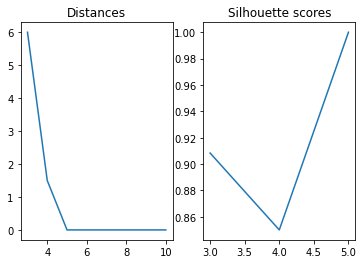

In [7]:
extractor = HMMLatentSegmentsExtractor(segment_len=3)

dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(np.array(test_trajs))
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

fig, axs = plt.subplots(1, 2)
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

TODO: Test the performance of the learning of the transition matrix.

### Learn segments from data

In [8]:
segment_length = 3
trajlets_for_segments_learning = traj_dataset.get_trajlets(length=segment_length*0.4, overlap=1, to_numpy=True)
print(trajlets_for_segments_learning.shape)

(6891, 3, 5)


In [9]:
extractor = HMMLatentSegmentsExtractor(segment_len=segment_length, n_min_centres=210, n_max_centres=230)
dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(trajlets_for_segments_learning[:, :, 0:4])
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

Text(0.5, 1.0, 'Silhouette scores')

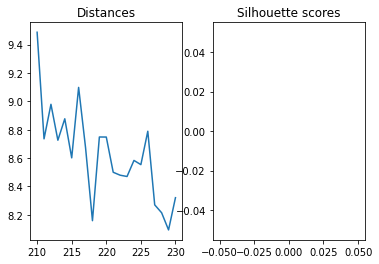

In [10]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

In [11]:
center_idx = 15
print(dists[center_idx])
center = np.array(centres[center_idx])

8.554122102520799


In [12]:
patterns = center.reshape([-1, 2, 3])
print(patterns)

[[[ 0.00000000e+00  3.89483212e-01  7.59501143e-01]
  [ 0.00000000e+00  3.27158499e-02  6.83767690e-03]]

 [[ 0.00000000e+00  7.33759445e-02  1.39617404e+00]
  [ 0.00000000e+00  4.37140534e-02  2.96351907e-01]]

 [[ 0.00000000e+00  1.01590234e+00  2.27779208e+00]
  [ 0.00000000e+00 -3.80520679e-01 -7.54721609e-01]]

 ...

 [[ 0.00000000e+00  4.09852945e-01  8.21199003e-01]
  [ 0.00000000e+00  6.32229580e-02  9.19799568e-02]]

 [[ 0.00000000e+00  3.99999685e-01  1.53650090e+00]
  [ 0.00000000e+00 -8.78839616e-08  2.41152383e-02]]

 [[ 0.00000000e+00  3.71038902e-01  8.27327408e-01]
  [ 0.00000000e+00 -4.48646975e-02  4.70015255e-02]]]


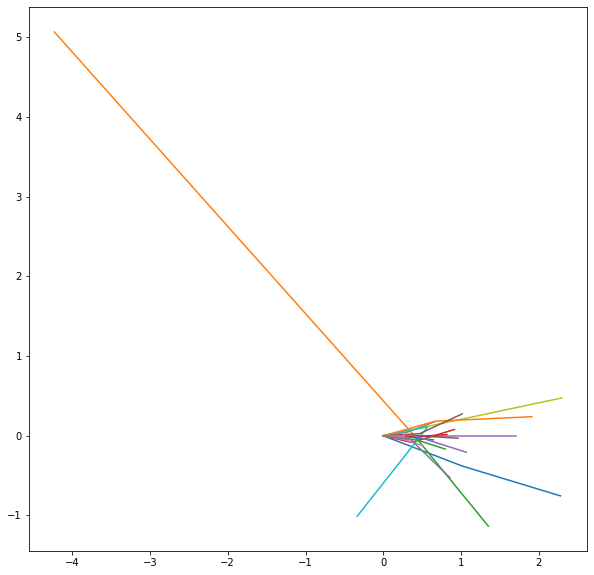

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for p in patterns[2:20, :, :]:
    axs.plot(p[0, :], p[1, :])

### Evaluate ADE and FDE performance on ETH dataset